# Laboratorium 2 - wieloręcy bandyci

## Przygotowanie

 * [opcjonalnie] Utwórz wirtualne środowisko
 `python3 -m venv ./recsyslab2`
 * zainstaluj potrzebne biblioteki:
 `pip3 install matplotlib tabulate`
 * upewnij się, że plik `bandit_framework.py` najduje się w tym samym katalogu

## Część 1. - framework i naiwni bandyci

In [180]:
# importujemy wszystkie potrzebne pakiety

from copy import copy
from itertools import product
from math import log, sqrt
from tabulate import tabulate
from random import betavariate, normalvariate, random, sample, shuffle, uniform
from bandit_framework import * # pakiet ze srodowiskiem testowym

In [181]:
# inicjalizujemy parametry testu

runs = 50
epochs = 100
recommendation_size = 10

In [182]:
# inicjalizujemy ramiona bandytow - payout kazdego ramienia bedzie reprezentowany przez rozklad normalny
#   te ramiona dobrze reprezentują CTR, czyli funkcje celu o rozkladzie Bernoulliego
#   - mamy prawdopodobienstwo aktywacji (klikniecia) p i staly payout po kliknieciu
# Mozemy takze przygotowac inne typy ramion, np. z payoutem losowanym z rozkladu normalnego lub wykladniczego

good_arms = [Arm(f'good_{i}', uniform(0.5, 0.7), lambda: 1) for i in range(10)]
bad_arms = [Arm(f'bad_{i}', uniform(0.1, 0.4), lambda: 1) for i in range(90)]
arms = {arm.arm_id: arm for arm in sample(good_arms+bad_arms, 100)}
arm_ids = list(arms.keys())

In [183]:
expected_highest_payout_per_epoch = sum(sorted([arm.activation_probability for arm in arms.values()], reverse=True)[:10])
print(f'Expected highest average payout per epoch: {expected_highest_payout_per_epoch}')

Expected highest average payout per epoch: 5.8133322909283205


In [184]:
# pierwszy bandyta - wybiera losowe ramiona

class Random(Bandit):
    def __init__(self, bandit_id, arm_ids):
        super().__init__(bandit_id, arm_ids)
    
    def recommend(self, size):
        return sample(self.arm_ids, size)
    
    def feedback(self, arm_id, payout):
        pass

In [185]:
# ten bandyta oszukuje - zna mozliwosci kazdego z ramion i wybiera najlepsze - przyda nam sie do porownania

class Perfect(Bandit):
    def __init__(self, bandit_id, arm_ids, arms):
        super().__init__(bandit_id, arm_ids)
        self.arms = arms
        self.expected_payouts = {}
        for arm in arms.values():
            self.expected_payouts[arm.arm_id] = self.__find_expected_value(arm.payout_function) * arm.activation_probability
        self.arm_ids_sorted_by_expected_payout = [x[0] for x in sorted(self.expected_payouts.items(), key=lambda x: x[1], reverse=True)]

    def recommend(self, size):
        return self.arm_ids_sorted_by_expected_payout[:size]
    
    def feedback(self, arm_id, payout):
        pass
    
    def __find_expected_value(self, payout_function, n=100000):
        # brzydka, ale skuteczna sztuczka, zeby metoda brute-force znalexc wartosc oczekiwana
        return sum([payout_function() for i in range(n)]) / n

In [186]:
# tworzymy liste bandytow do przetestowania

bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]

In [187]:
# uruchamiamy test

runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect



Aggregated results:

perfect: 583.54
random: 295.3600000000001


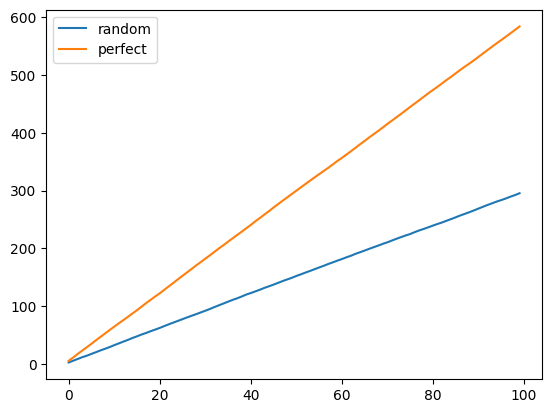

In [188]:
# wyniki sumaryczne dla wszystkich epok

runner.plot_results(results, runs, epochs, mode='cumulative')


Aggregated results:

perfect: 5.96
random: 3.18


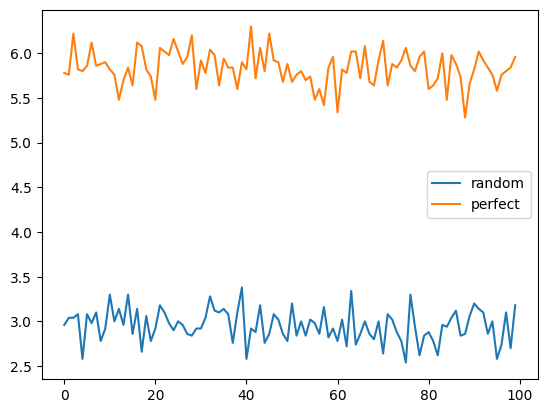

In [189]:
# wyniki per epoka

runner.plot_results(results, runs, epochs, mode='average')

## Część 2. - bandyci właściwi

In [190]:
class EGreedy(Bandit):
    def __init__(self, bandit_id, arm_ids, epsilon):
        super().__init__(bandit_id, arm_ids)
        self.epsilon = epsilon

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
    
    def recommend(self, size):
        random_arm_ids = copy(self.arm_ids)
        shuffle(random_arm_ids)

        best_arm_ids = sorted(
            self.payouts_per_recommendation.items(),
            key = lambda item: item[1],
            reverse = True
        )

        result = []
        idx = 0

        while len(result) < size:
            if random() <= self.epsilon:
                choice = random_arm_ids[idx]
            else:
                choice = best_arm_ids[idx][0]
                
            if choice not in result:
                result.append(choice)
                self.recommended_rates[choice] += 1
            #

            idx = (idx + 1) % len(self.arm_ids)
        #

        return result 
    #
    
    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
    #
#

In [ ]:
class UCB(Bandit):
    def __init__(self, bandit_id, arm_ids, optimism_weight):
        super().__init__(bandit_id, arm_ids)
        self.optimism_weight = optimism_weight

        self.recommended_rates = {arm_id: 0 for arm_id in arm_ids}
        self.activation_rates = {arm_id: 0 for arm_id in arm_ids}
        self.payouts = {arm_id: 0.0 for arm_id in arm_ids}
        self.payouts_per_recommendation = {arm_id: 0.0 for arm_id in arm_ids}
        self.n = 0
    #

    def recommend(self, size):
        best_arm_ids = sorted(
            self.payouts_per_recommendation.items(),
            key = lambda item: item[1] + self._optimism(item[0]),
            reverse = True
        )
        self.n += size 

        for arm_id, _ in best_arm_ids[:size]:
            self.recommended_rates[arm_id] += 1
        return [arm_id for (arm_id, _) in best_arm_ids[:size]]
    #
    
    def feedback(self, arm_id, payout):
        self.payouts[arm_id] += payout 
        self.payouts_per_recommendation[arm_id] = self.payouts[arm_id] / self.recommended_rates[arm_id]
        # self.activation_rates[arm_id] += 1

    def _optimism(self, arm_id):
        if self.recommended_rates[arm_id] == 0:
            return 1.0 # return float('inf')
        return self.optimism_weight * sqrt(2 * log(self.n) / self.recommended_rates[arm_id])

In [192]:
class ThompsonSampling(Bandit):
    def __init__(self, bandit_id, arm_ids, reward_multiplier, regret_multiplier):
        super().__init__(bandit_id, arm_ids)
        self.reward_multiplier = reward_multiplier
        self.regret_multiplier = regret_multiplier
        self.a = {arm_id: 1 for arm_id in arm_ids}
        self.b = {arm_id: 1 for arm_id in arm_ids}
    #

    def recommend(self, size):
        sample_arms_dict = {arm_id: betavariate(self.a[arm_id], self.b[arm_id]) for arm_id in self.arm_ids}
        best_arm_ids = sorted(
            sample_arms_dict.items(),
            key = lambda item: item[1],
            reverse = True
        )
        return [arm_id for (arm_id, _) in best_arm_ids[:size]]
    #

    def feedback(self, arm_id, payout):
        if payout > 0:
            self.a[arm_id] += self.reward_multiplier * payout
        else:
            self.b[arm_id] += self.regret_multiplier * (1 - payout)
    #
#

## Część 3. - zgrubne porównanie bandytów

In [193]:
bandits = [
    Random('random', arm_ids),
    Perfect('perfect', arm_ids, arms)
]
# nie wahaj sie wybrac innych wartosci parametrow bandytow
bandits.extend([EGreedy('egreedy_%s' % epsilon, arm_ids, epsilon) for epsilon in [0.01, 0.05, 0.1, 0.25]])
bandits.extend([UCB('ucb_%s' % optimism_weight, arm_ids, optimism_weight) for optimism_weight in [0.01, 0.1, 1, 10]])
bandits.extend([ThompsonSampling('ts_%s_%s' % (reward_weight, regret_weight), arm_ids, reward_weight, regret_weight)
                for reward_weight, regret_weight in product([1, 5, 10, 20, 50], [1, 5, 10, 20, 50])])

In [194]:
runner = Runner(arms, bandits)
results = runner.simulate(runs, epochs, recommendation_size)

Simulating: random
Simulating: perfect
Simulating: egreedy_0.01
Simulating: egreedy_0.05
Simulating: egreedy_0.1
Simulating: egreedy_0.25
Simulating: ucb_0.01
Simulating: ucb_0.1
Simulating: ucb_1
Simulating: ucb_10
Simulating: ts_1_1
Simulating: ts_1_5
Simulating: ts_1_10
Simulating: ts_1_20
Simulating: ts_1_50
Simulating: ts_5_1
Simulating: ts_5_5
Simulating: ts_5_10
Simulating: ts_5_20
Simulating: ts_5_50
Simulating: ts_10_1
Simulating: ts_10_5
Simulating: ts_10_10
Simulating: ts_10_20
Simulating: ts_10_50
Simulating: ts_20_1
Simulating: ts_20_5
Simulating: ts_20_10
Simulating: ts_20_20
Simulating: ts_20_50
Simulating: ts_50_1
Simulating: ts_50_5
Simulating: ts_50_10
Simulating: ts_50_20
Simulating: ts_50_50



Aggregated results:

ts_5_10: 6.02
ucb_0.1: 5.86
perfect: 5.84
ts_1_20: 5.8
ts_1_10: 5.78
ts_10_50: 5.78
ts_1_50: 5.76
ts_1_5: 5.7
ts_20_10: 5.7
ts_5_5: 5.62
egreedy_0.05: 5.52
ts_50_5: 5.5
ts_10_5: 5.48
ts_20_20: 5.48
egreedy_0.1: 5.46
ts_5_20: 5.44
ts_20_1: 5.42
ts_5_50: 5.4
ts_5_1: 5.36
ts_10_10: 5.34
ts_10_20: 5.32
ts_1_1: 5.28
ts_10_1: 5.24
egreedy_0.01: 5.16
ts_50_1: 5.12
ts_20_5: 5.08
egreedy_0.25: 5.06
ucb_1: 4.94
ts_50_20: 4.78
ts_20_50: 4.76
ucb_0.01: 4.7
ts_50_10: 4.62
ts_50_50: 3.88
ucb_10: 3.6
random: 2.98


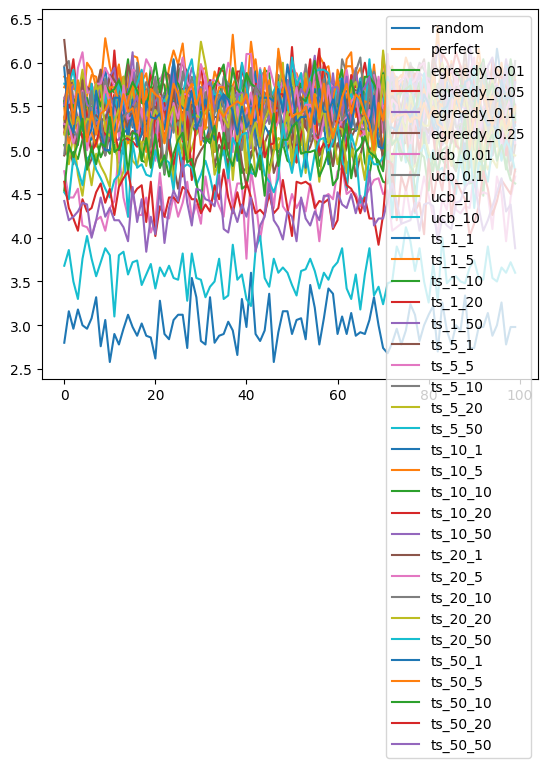

In [195]:
runner.plot_results(results, runs, epochs, mode='average')


Aggregated results:

perfect: 579.74
ts_5_5: 573.1
ucb_0.1: 570.2
ts_5_1: 568.9200000000002
ts_1_20: 567.8600000000001
ts_1_5: 567.04
ts_1_50: 566.4
ts_10_10: 564.02
ts_1_10: 562.7799999999997
ts_5_50: 561.8
ts_5_10: 560.82
ts_1_1: 557.3599999999999
egreedy_0.05: 554.1999999999999
ts_5_20: 552.74
ts_10_50: 550.9000000000001
ts_10_5: 549.46
ts_50_5: 545.88
ts_50_1: 544.02
ts_20_5: 538.92
egreedy_0.1: 538.2199999999999
ts_20_10: 537.42
ts_20_1: 535.82
ts_10_1: 530.3800000000001
ts_20_20: 528.7799999999996
ts_10_20: 520.1599999999997
egreedy_0.01: 503.56000000000023
egreedy_0.25: 503.5400000000002
ucb_1: 498.9999999999999
ts_50_10: 494.88
ts_20_50: 482.88
ts_50_20: 445.02000000000004
ucb_0.01: 441.08000000000015
ts_50_50: 430.6399999999999
ucb_10: 360.10000000000014
random: 299.78000000000003


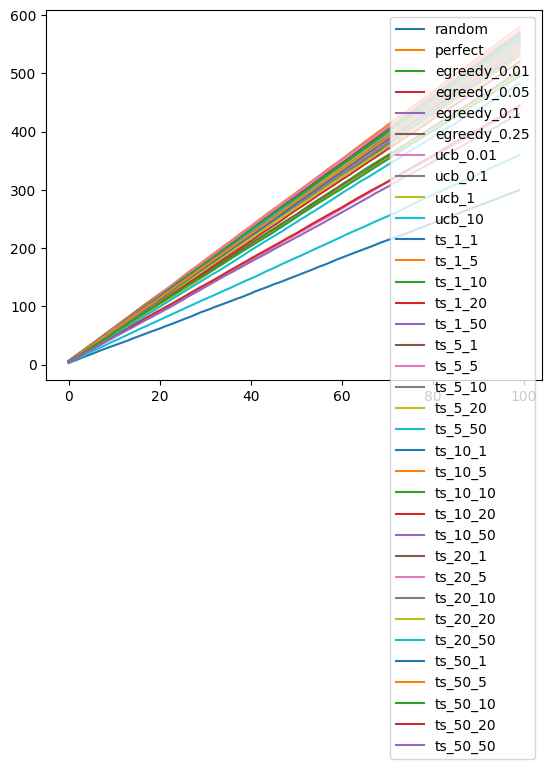

In [196]:
runner.plot_results(results, runs, epochs, mode='cumulative')

## Część 4. - dokładne porównanie bandytów

In [197]:
# obliczmy liste wszystkich dobrych ramion (arm_id zaczyna sie od 'good_') w rekomendacji
def relevant(recommendation: List[Arm]) -> int:
    return len([arm for arm in recommendation if arm.arm_id.startswith('good')])

all_relevant = relevant(arms.values())

In [198]:
# obliczmy precision@k i recall@k (na bazie funkcji relevant())

# liczba trafnych rekomendacji w top-k / k
def precision_at_k(recommendation: List[Arm], k: int) -> float:
    recommendation_k = recommendation[:k]
    return relevant(recommendation_k) / k

# liczba trafnych rekomendacji w top-k / liczba wszystkich trafnych elementow
def recall_at_k(recommendation: List[Arm], k: int, all_relevant: int) -> float:
    recommendation_k = recommendation[:k]
    
    if all_relevant == 0: return 0
    return relevant(recommendation_k) / all_relevant

In [199]:
# sprawdzmy, czy dziala
sample_bandit = bandits[-1]
k = 3
recommendation_ids = sample_bandit.recommend(recommendation_size)
recommendation = [arms[arm_id] for arm_id in recommendation_ids]
print(f'Precision@{k} for bandit {sample_bandit.bandit_id}: {precision_at_k(recommendation, k)}')
print(f'Recall@{k} for bandit {sample_bandit.bandit_id}: {recall_at_k(recommendation, k, all_relevant)}')

Precision@3 for bandit ts_50_50: 1.0
Recall@3 for bandit ts_50_50: 0.3


In [200]:
class TestEntry():
    def __init__(self, bandit_name: str, k: int, precision: float, recall: float):
        self.bandit_name = bandit_name
        self.k = k
        self.precision = precision
        self.recall = recall
    
    def tuple(self):
        return (self.bandit_name, self.k, self.precision, self.recall)


def print_test_results(entries: List[TestEntry]):
    data = sorted(sorted([e.tuple() for e in entries], key=lambda e: e[1]), key=lambda e: e[0])
    headers = ('bandit', 'k', 'precision@k', 'recall@k')
    print(tabulate(data, headers, tablefmt='github'))

In [201]:
# wybieramy kilku istniejacych, wytrenowanych bandytow (perfect, random, po jednym e-greedy, UCB, TS)
testing_bandits = [
    bandit for bandit in bandits
    if bandit.bandit_id in ['perfect', 'random', 'egreedy_0.1', 'ucb_1', 'ts_10_50']
]
# wybieramy wartosci k do porownania
k_vals = [3, 5, 10]
# bedziemy liczyc sredni precision i recall dla `samples` rekomendacji
samples = 10
# miejsce na wyniki
results = []

# dla kazdego bandyty - generujemy `samples` rekomendacji, liczymy precision i recall, zapisujemy srednie wartosci
# powtarzamy dla kazdego k

# uwaga! przed przeprowadzeniem porownania, bandyci musza sie nauczyc
# pamietaj o uruchomieniu `runner.simulate()` w poprzedniej czesci

def calculate_metrics(testing_bandits):
    for k in k_vals:
        print(f'Precision@{k}, recall@{k}: ')

        for bandit in testing_bandits:
            print(f'Bandit_id: {bandit.bandit_id}')
            precision, recall = 0.0, 0.0

            for _ in range(samples):
                recommendation = bandit.recommend(samples)
                recommended_arms = [arms[arm_id] for arm_id in recommendation]

                precision += precision_at_k(recommended_arms, k)
                recall    += recall_at_k(recommended_arms, k, relevant(recommended_arms))
            #

            results.append(
                TestEntry(bandit.bandit_id, k, precision / samples, recall / samples)
            )
        #
    #
#

calculate_metrics(testing_bandits)
print_test_results(results)

Precision@3, recall@3: 
Bandit_id: random
Bandit_id: perfect
Bandit_id: egreedy_0.1
Bandit_id: ucb_1
Bandit_id: ts_10_50
Precision@5, recall@5: 
Bandit_id: random
Bandit_id: perfect
Bandit_id: egreedy_0.1
Bandit_id: ucb_1
Bandit_id: ts_10_50
Precision@10, recall@10: 
Bandit_id: random
Bandit_id: perfect
Bandit_id: egreedy_0.1
Bandit_id: ucb_1
Bandit_id: ts_10_50
| bandit      |   k |   precision@k |   recall@k |
|-------------|-----|---------------|------------|
| egreedy_0.1 |   3 |      0.933333 |   0.311905 |
| egreedy_0.1 |   5 |      0.88     |   0.498214 |
| egreedy_0.1 |  10 |      0.9      |   1        |
| perfect     |   3 |      1        |   0.3      |
| perfect     |   5 |      1        |   0.5      |
| perfect     |  10 |      1        |   1        |
| random      |   3 |      0.1      |   0.25     |
| random      |   5 |      0.14     |   0.341667 |
| random      |  10 |      0.12     |   0.7      |
| ts_10_50    |   3 |      1        |   0.375    |
| ts_10_50    |   5 |  